## Topic Modelling speeches using LDA (Latent Dirichlet Allocation) algorithm

We have downloaded some speeches by B. Obama and M. Romney made during US Presidential election 2012. The speeches are uploaded on GitHUB and we would try to find some imortant topics each of their speeches consisted of. 

We have worked on cleaning the speeches in a separate notebook and hence we will concentrate on Topic modelling in this Notebook which means you might have to go back to Data cleaning notebook in case you want to do further cleaning for the betterment of the modelling. This is done to better manage the code.

The model we're designing here would make use of Gensim and visualization packages like matplotlib, wordcloud and wounder LDA visualization package called pyLDAvis.

In [40]:
# To find folders and text under a given path
import os

# For dataframe/tables
import pandas as pd
import numpy as np

# Default dictionary and counter
from collections import defaultdict, Counter

# Gensim
from gensim import corpora
from gensim import models

# Model evaluation
from gensim.models import CoherenceModel

# Visualization - plots, word cloud and LDA visualization
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# Suppress deprecation and future warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



Load all corpus and dictionary that we have stored after cleaning the speeches.

In [41]:
# corpus folder
folder = 'tmp'

# Corpus 
corpus_bow = dict()

# Load the corpus
for fld in next(os.walk(folder))[1] :
    for corpus in os.listdir(folder + os.sep + fld):
        file = os.getcwd() + os.sep + folder + os.sep + fld + os.sep + corpus
        if os.path.splitext(file)[1] == '.mm' :
            corpus_bow[fld] = list(corpora.mmcorpus.MmCorpus(file))            

# dictionary 
for item in next(os.walk(folder))[2] :
    file = os.getcwd() + os.sep + folder + os.sep + item
    if os.path.splitext(file)[1] == '.dict' :        
        corpus_dict = corpora.Dictionary.load(file)


In [42]:
# Transform corpus to Tf-idf
corpus_tfidf = dict()
for fld in corpus_bow.keys() :    
    Tfidf = models.TfidfModel(corpus_bow[fld], smartirs='ntc')
    corpus_tfidf[fld] = Tfidf[corpus_bow[fld]]    


In [43]:
# Create word tokens using downloaded corpus and dictionary
textlist = dict()
for fld in corpus_tfidf.keys() :
    textlist[fld] = [[corpus_dict[text_tup[0]] for text_tup in doc for _ in range(int(text_tup[1]))] for doc in corpus_bow[fld]]

## Analysis of Romney's speeches

In [44]:
# LDA model - grid search the number of optimum topics (Try different values in the for loop)
num_of_passes = 10
x = defaultdict(list); y = defaultdict(list); z = defaultdict(list)
fld = 'romney'

for num_topics in range(6,21,1) :
    lda_model = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics, passes = num_of_passes,\
                                  chunksize=100, random_state=123, update_every=1)
    coherence_model_lda = CoherenceModel(model=lda_model,texts = np.squeeze(textlist[fld]), dictionary=corpus_dict, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()        
    x[fld].append(num_topics) ; y[fld].append(coherence_score)
    print("{}'s speech : Number of topics is {}, coherence score is {}".format(fld,num_topics,coherence_score))


romney's speech : Number of topics is 6, coherence score is 0.6401647326180719
romney's speech : Number of topics is 7, coherence score is 0.5200713283513657
romney's speech : Number of topics is 8, coherence score is 0.6605303988906828
romney's speech : Number of topics is 9, coherence score is 0.6503916687668478
romney's speech : Number of topics is 10, coherence score is 0.5686472461172393
romney's speech : Number of topics is 11, coherence score is 0.5856653088456653
romney's speech : Number of topics is 12, coherence score is 0.6063284790387485
romney's speech : Number of topics is 13, coherence score is 0.5489878571824715
romney's speech : Number of topics is 14, coherence score is 0.5864512111727479
romney's speech : Number of topics is 15, coherence score is 0.5586578044480234
romney's speech : Number of topics is 16, coherence score is 0.5365315182261232
romney's speech : Number of topics is 17, coherence score is 0.5364744251663706
romney's speech : Number of topics is 18, co

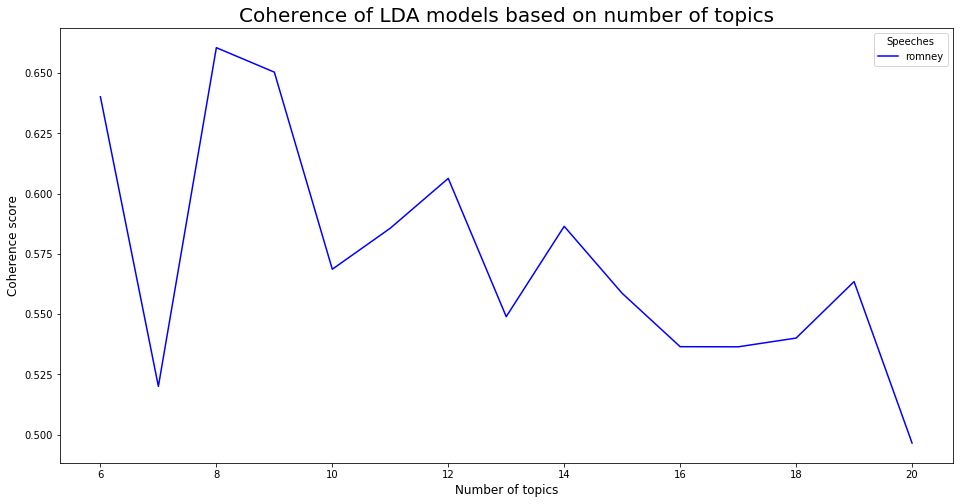

In [45]:
# Plot the coherence (using the grid search result)
plt.figure(figsize=(16,8))
fld = 'romney'
col = 'blue'
plt.plot(x[fld],y[fld], color=col, label=fld)
plt.legend(title='Speeches')
plt.title("Coherence of LDA models based on number of topics", fontsize=20)
plt.ylabel("Coherence score",fontsize=12)
plt.xlabel("Number of topics",fontsize=12)
plt.show()

Based on the plot, it seems the optimum value of number of topics is 8 however since topic modelling is unsupervised modelling techniques, value of coherence and perplexity are indicative only. One should also look at wordcloud of each topic, topic - document distibution and importance and most importantly pyLDAvis output before deciding on number of topics for final model - this would be a try and error method.

In [46]:
# LDA - final model (Romney's speech)
fld = 'romney'
num_of_passes = 10
lda = dict(); num_topics = dict()
num_topics[fld] = 8
num_words = 15

lda[fld] = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics[fld], passes = num_of_passes,\
                        chunksize=100, random_state=123, update_every=1)
model_perplexity = lda[fld].log_perplexity(corpus_tfidf[fld])
print("Model perplexity for {} is {}".format(fld,model_perplexity))


Model perplexity for romney is -13.328344461683901


In [47]:
# Analyse the topic distribution of speeches
fld='romney'
threshold = 20.0 # To suppress the topic contribution in a document if less than the percentage in threshold
columns = ["Topic " + str(i+1) for i in range(num_topics[fld])]
df_topicdist = dict()
df_topicdist[fld] = pd.DataFrame(columns=columns)
topic_dist = lda[fld][corpus_tfidf[fld]]
for indx, doc_dist in enumerate(topic_dist):
    row =  dict(doc_dist)  
    df_topicdist[fld].loc[indx] = [row[i]*100 if i in row.keys() and row[i]*100 > threshold else 0 for i in range(num_topics[fld])]
    

In [48]:
# Topic by Importance (based on contribution in each speech)
df_topic_imp = pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance'])
df_topic_imp = df_topic_imp*100/df_topic_imp.sum(axis=0)
topic_imp = df_topic_imp.iloc[:,0]
topic_imp

Topic 1     4.541136
Topic 2    16.251487
Topic 3     8.331178
Topic 4    14.027078
Topic 5     3.277948
Topic 6     4.146916
Topic 7    19.808249
Topic 8    29.616008
Name: Importance, dtype: float64

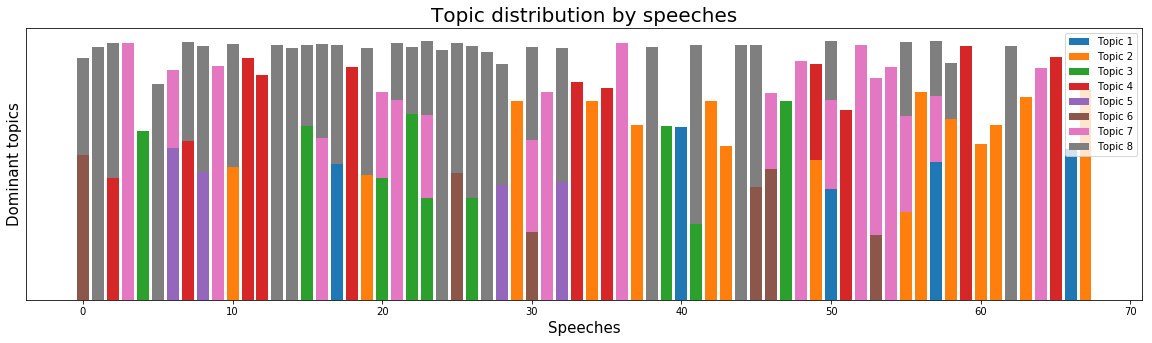

In [49]:
# Plot the topic distribution across documents/speeches
fld = 'romney'
topic_order = np.arange(num_topics[fld])

plt.figure(figsize=(20,5))

bottom_bar = np.zeros(shape = len(corpus_tfidf[fld]))
for idx, topic_id in enumerate(topic_order) :
    distribution = np.array(df_topicdist[fld].iloc[:,topic_id])
    if bottom_bar.all == np.zeros :
        plt.bar(x=np.arange(len(corpus_tfidf[fld])), height=distribution, bottom=None, label = "Topic "+str(idx+1))
        bottom_bar = distribution
    else :
        plt.bar(x=np.arange(len(corpus_tfidf[fld])), height=distribution, bottom=bottom_bar, label = "Topic "+str(idx+1))
        bottom_bar += distribution
  
plt.xlabel("Speeches",fontsize=15)
plt.ylabel("Dominant topics",fontsize=15)
plt.title("Topic distribution by speeches", fontsize=20)
plt.yticks([])
plt.legend(loc='upper right')
plt.show()

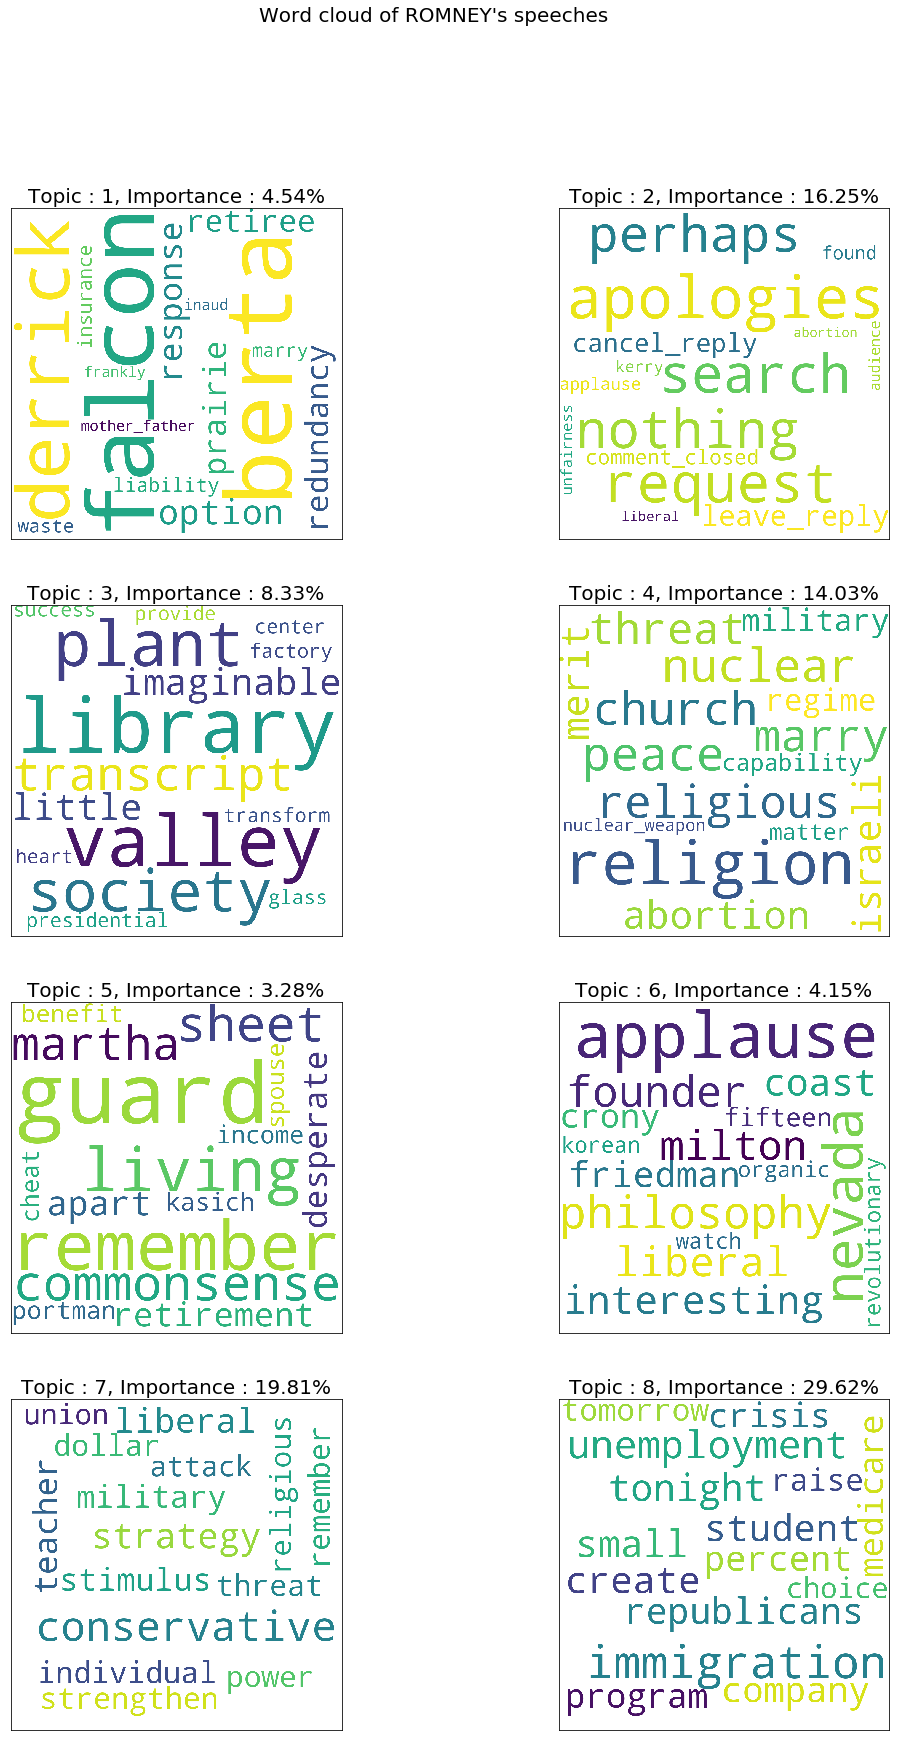

In [50]:
# Display all topics from Romney's speeches using wordcloud
fld = 'romney'

topic_order = np.arange(num_topics[fld])

topics = lda[fld].show_topics(formatted=False, num_words = num_words)
topics = [[topic_order[id],topic] for id,topic in topics]

wordcloud = WordCloud(width=1200,height=1200,
                     background_color='white', min_font_size=10)
fig, ax = plt.subplots(int(np.ceil(num_topics[fld]/2)),2, figsize=(18,28),sharex=True,sharey=True)

for topic_id,content in topics :    
    fig.add_subplot(ax.flatten()[topic_id])
    topic_dict = dict(content)   
    wordcloud.generate_from_frequencies(topic_dict)
    plt.imshow(wordcloud)
    plt.xticks([])
    plt.yticks([])    
    plt.title("Topic : " + str(topic_id+1) + ", Importance : " + str(round(topic_imp[topic_id],2))+'%',fontsize=20)
    

plt.suptitle("Word cloud of " + fld.upper() + "'s speeches", fontsize=20)
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.margins(x=0,y=0)
plt.show()
    

In [51]:
# Visualize - LDA using pyLDAvis (Romney's speeches)
vis = dict()
fld='romney'
vis[fld] = pyLDAvis.gensim.prepare(lda[fld],corpus=corpus_tfidf[fld],dictionary=corpus_dict, mds = 'mmds')

**Note :** A good Topic model using LDA would have a well separated topic circles in pyLDAvis however as previously explained this should NOT be the only criteria for choosing the right parameters like number of topics. A wordcloud should be analyzed to make sense of each topic which is an important step towards getting the right output. Also note that pyLDAvis numbers each topic by its relevance across documents (in contrast to gensim output) and uses its own method to derive the relevance (may slightly differ from the calculation of topic importance we did) and topic relevance is proportional to area of the circle.

In [52]:
# Print topics in Romney's speeches
print("Speech by ",fld)
vis[fld]

Speech by  romney


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      32.287468        1       1 -0.010916  0.012551
6      23.087847        1       2  0.004845  0.008896
3      15.599467        1       3  0.008407 -0.003125
1       8.143631        1       4 -0.006476 -0.005140
2       8.095948        1       5  0.003485 -0.001110
5       4.474608        1       6  0.000015 -0.002372
0       4.413642        1       7 -0.001010 -0.004982
4       3.897382        1       8  0.001651 -0.004718, topic_info=     Category      Freq            Term     Total  loglift  logprob
term                                                               
1382  Default  0.000000       apologies  0.000000  30.0000  30.0000
2024  Default  0.000000         request  0.000000  29.0000  29.0000
3190  Default  0.000000          search  0.000000  28.0000  28.0000
770   Default  0.000000         nothing  0.000000  27.0000  27.0000
4814  Default  0.000000         perhaps  0.000000  26.0000  26.0000
8097  Default  0.000000    cancel_reply  0.000000  25.0000  25.0000
1839  Default  0.000000     leave_reply  0.000000  24.0000  24.0000
3690  Default  0.000000        applause  0.000000  23.0000  23.0000
7438  Default  0.000000  comment_closed  0.000000  22.0000  22.0000
2843  Default  0.000000           found  0.000000  21.0000  21.0000
8186  Default  0.000000          falcon  0.000000  20.0000  20.0000
5383  Default  0.000000           berta  0.000000  19.0000  19.0000
3310  Default  0.000000        religion  0.000000  18.0000  18.0000
4218  Default  0.000000          nevada  0.000000  17.0000  17.0000
2116  Default  0.000000         library  0.000000  16.0000  16.0000
5853  Default  0.000000    conservative  0.000000  15.0000  15.0000
342   Default  0.000000         liberal  0.000000  14.0000  14.0000
2721  Default  0.000000           kerry  0.000000  13.0000  13.0000
4803  Default  0.000000           guard  0.000000  12.0000  12.0000
1763  Default  0.000000     immigration  0.000000  11.0000  11.0000
3309  Default  0.000000          valley  0.000000  10.0000  10.0000
8207  Default  0.000000        remember  0.000000   9.0000   9.0000
1107  Default  0.000000        audience  0.000000   8.0000   8.0000
4239  Default  0.000000      unfairness  0.000000   7.0000   7.0000
6064  Default  0.000000      philosophy  0.000000   6.0000   6.0000
4012  Default  0.000000         derrick  0.000000   5.0000   5.0000
2900  Default  0.000000        abortion  0.000000   4.0000   4.0000
2461  Default  0.000000        strategy  0.000000   3.0000   3.0000
3990  Default  0.000000           plant  0.000000   2.0000   2.0000
814   Default  0.000000         veteran  0.000000   1.0000   1.0000
...       ...       ...             ...       ...      ...      ...
6708   Topic8  0.009275           smell  0.099001   0.8770  -8.2370
6723   Topic8  0.009403        disgrace  0.102739   0.8537  -8.2233
7445   Topic8  0.009152          dorene  0.100021   0.8534  -8.2504
3886   Topic8  0.009231     superiority  0.103113   0.8316  -8.2417
5499   Topic8  0.008736         refrain  0.098862   0.8186  -8.2969
2181   Topic8  0.008735          bigger  0.098867   0.8184  -8.2970
2919   Topic8  0.008729          amidst  0.098902   0.8174  -8.2977
6206   Topic8  0.008729         bloated  0.098906   0.8173  -8.2977
5748   Topic8  0.008728   disappointing  0.098910   0.8172  -8.2978
3157   Topic8  0.008717           lofty  0.098980   0.8152  -8.2991
8154   Topic8  0.008658           motor  0.098527   0.8130  -8.3059
4348   Topic8  0.008657         hampton  0.098529   0.8129  -8.3060
1532   Topic8  0.008657     eligibility  0.098530   0.8128  -8.3060
1199   Topic8  0.008699          bitter  0.099086   0.8121  -8.3011
1693   Topic8  0.008697         granite  0.099098   0.8118  -8.3013
1184   Topic8  0.009872          spouse  0.113553   0.8023  -8.1747
5451   Topic8  0.009296      everywhere  0.108865   0.7844  -8.2347
4199   Topic8  0.

## Analysis of Obama's speeches

We would now analyze Obama's speeches in similar way. Please note that many of the code that follow are similar to the way we processed Romney's speeches and hence defining them as functions would have been ideal for re-use however by doing so we will not be able to tweak the code for benefit for each model.

To start with we would grid search the number of models using coherence and perplexity - this would be try and error method again

In [53]:
# LDA model - grid search on number of topics
num_of_passes = 10
x = defaultdict(list); y = defaultdict(list); z = defaultdict(list)
fld = 'obama'
for num_topics in range(20,101,4) :
    lda_model = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics, passes = num_of_passes,\
                                  chunksize=100, random_state=123, update_every=1)
    coherence_model_lda = CoherenceModel(model=lda_model,texts = np.squeeze(textlist[fld]), dictionary=corpus_dict, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()        
    x[fld].append(num_topics) ; y[fld].append(coherence_score)
    print("{}'s speech : Number of topics is {}, coherence score is {}".format(fld,num_topics,coherence_score))


obama's speech : Number of topics is 20, coherence score is 0.45296827064689077
obama's speech : Number of topics is 24, coherence score is 0.4627490148341454
obama's speech : Number of topics is 28, coherence score is 0.41920523997049036
obama's speech : Number of topics is 32, coherence score is 0.5203257926777538
obama's speech : Number of topics is 36, coherence score is 0.4986423866296678
obama's speech : Number of topics is 40, coherence score is 0.4788414171007715
obama's speech : Number of topics is 44, coherence score is 0.5097965301396824
obama's speech : Number of topics is 48, coherence score is 0.5135243581329815
obama's speech : Number of topics is 52, coherence score is 0.5429020767709611
obama's speech : Number of topics is 56, coherence score is 0.5215667007059474
obama's speech : Number of topics is 60, coherence score is 0.5820971166815284
obama's speech : Number of topics is 64, coherence score is 0.5350402275068529
obama's speech : Number of topics is 68, coherence

C:\Users\acer\Anaconda3\envs\py35\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


obama's speech : Number of topics is 100, coherence score is 0.5302321061063179


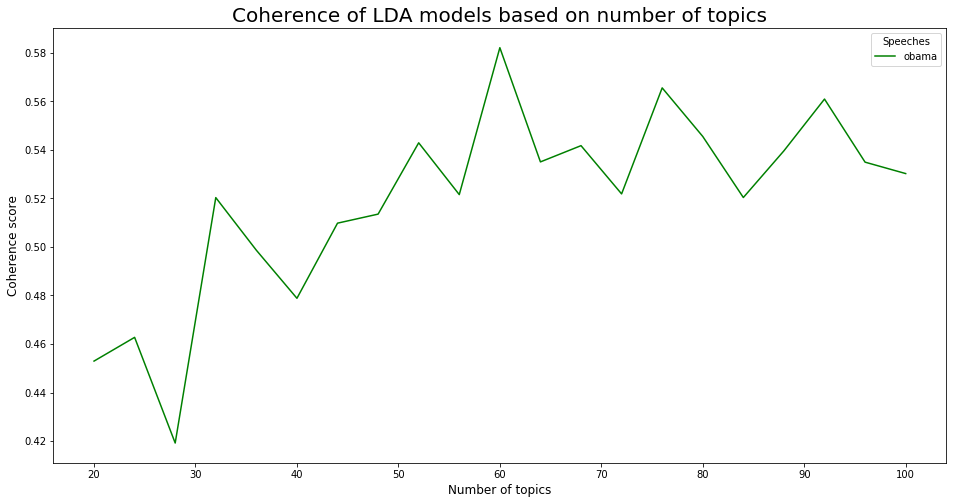

In [54]:
# Plot the coherence (output from grid search)
plt.figure(figsize=(16,8))
fld = 'obama'
col = 'green'
plt.plot(x[fld],y[fld], color=col, label=fld)
plt.legend(title='Speeches')
plt.title("Coherence of LDA models based on number of topics", fontsize=20)
plt.ylabel("Coherence score",fontsize=12)
plt.xlabel("Number of topics",fontsize=12)
plt.show()

Optimum value of number of topics is 60 however we would also look at other measures as explained before.

In [55]:
# LDA - final model (Obama's speech)
fld = 'obama'
num_of_passes = 20
lda = dict(); num_topics = dict()
num_topics[fld] = 60
num_words = 15

lda[fld] = models.LdaModel(corpus_tfidf[fld], id2word=corpus_dict, num_topics=num_topics[fld], passes = num_of_passes,\
                        chunksize=100, random_state=123, update_every=1)
model_perplexity = lda_model.log_perplexity(corpus_tfidf[fld])
print("Model perplexity for {} is {}".format(fld,model_perplexity))




Model perplexity for obama is -29.030924297157497


In [56]:
# Analyse the topic distribution of speeches by Obama
fld='obama'
threshold = 10.0 # To suppress the topic contribution in a document if less than the percentage in threshold
columns = ["Topic " + str(i+1) for i in range(num_topics[fld])]
df_topicdist = dict()
df_topicdist[fld] = pd.DataFrame(columns=columns)
topic_dist = lda[fld][corpus_tfidf[fld]]
for indx, doc_dist in enumerate(topic_dist):
    row =  dict(doc_dist)  
    df_topicdist[fld].loc[indx] = [row[i]*100 if i in row.keys() and row[i]*100 > threshold else 0 for i in range(num_topics[fld])]
    


In [57]:
# Top n Topic by Importance (based on contribution in each speech)
topn = 8
df_topic_imp = pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance']).sort_values('Importance', ascending = False)
df_topic_imp = df_topic_imp*100/df_topic_imp.sum(axis=0)
topic_imp = df_topic_imp.iloc[:,0]
topic_imp[:topn]

Topic 18    13.360086
Topic 32    11.967661
Topic 26     7.000857
Topic 16     5.851339
Topic 30     5.476850
Topic 2      4.492503
Topic 58     3.330540
Topic 38     2.580242
Name: Importance, dtype: float64

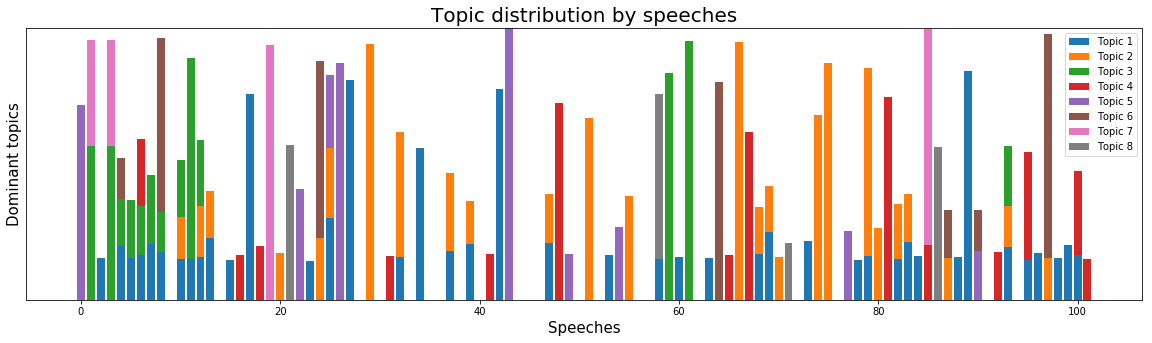

In [58]:
# Topic distribution of topn topics over speeches
fld = 'obama'
topn = 8
topic_order =  [int(indx[6:])-1 for indx in \
                pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance']).sort_values('Importance', ascending = False).index]
#topic_order = np.arange(num_topics[fld])

plt.figure(figsize=(20,5))

bottom_bar = np.zeros(shape = len(corpus_tfidf[fld]))
for idx, topic_id in enumerate(topic_order) :
    if idx < topn :
        distribution = np.array(df_topicdist[fld].iloc[:,topic_id])
        if bottom_bar.all == np.zeros :
            plt.bar(x=np.arange(len(corpus_tfidf[fld])), height=distribution, bottom=None, label = "Topic "+str(idx+1))
            bottom_bar = distribution
        else :
            plt.bar(x=np.arange(len(corpus_tfidf[fld])), height=distribution, bottom=bottom_bar, label = "Topic "+str(idx+1))
            bottom_bar += distribution
  
plt.xlabel("Speeches",fontsize=15)
plt.ylabel("Dominant topics",fontsize=15)
plt.title("Topic distribution by speeches", fontsize=20)
plt.yticks([])
plt.legend(loc='upper right')
plt.show()

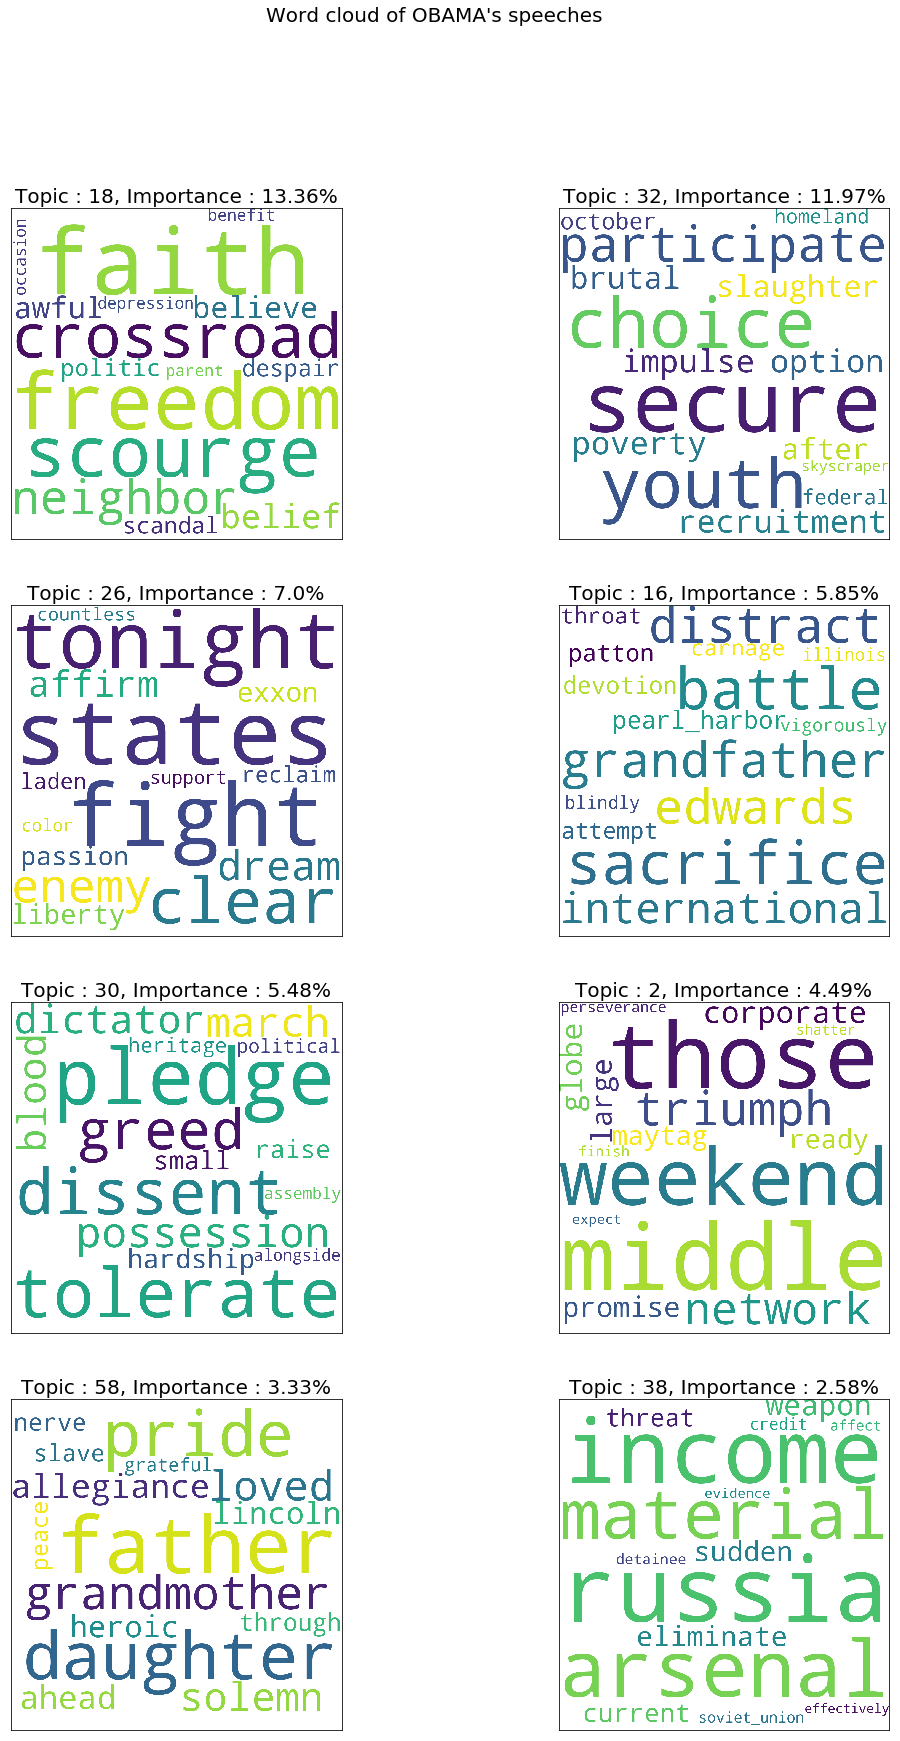

In [59]:
# Display topn topics from Obama's speeches
fld = 'obama'
topn = 8
num_topics=dict()
num_topics[fld] = 60
topic_order =  [int(indx[6:])-1 for indx in \
                pd.DataFrame(df_topicdist[fld].sum(axis=0),columns=['Importance']).sort_values('Importance', ascending = False).index]
wordcloud = WordCloud(width=1200,height=1200,
                     background_color='white', min_font_size=10)
fig, ax = plt.subplots(int(np.ceil(topn/2)),2, figsize=(18,28),sharex=True,sharey=True)

for tid, topic_id in enumerate(topic_order[:topn]) :
    content = lda[fld].show_topic(topic_id, num_words)
    fig.add_subplot(ax.flatten()[tid])
    topic_dict = dict(content)   
    wordcloud.generate_from_frequencies(topic_dict)
    plt.imshow(wordcloud)
    plt.xticks([])
    plt.yticks([])    
    plt.title("Topic : " + str(topic_id+1) + ", Importance : " + str(round(topic_imp[tid],2))+'%',fontsize=20)

plt.suptitle("Word cloud of " + fld.upper() + "'s speeches", fontsize=20)
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.margins(x=0,y=0)
plt.show()
    

In [60]:
# Visualize - LDA using pyLDAvis (Obama's speeches)
fld='obama'
vis[fld] = pyLDAvis.gensim.prepare(lda[fld],corpus=corpus_tfidf[fld],dictionary=corpus_dict, mds = 'mmds')

In [61]:
# Print topics in Obama's speeches
print("Speeches by ",fld)
vis[fld]

Speeches by  obama


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
17     11.756090        1       1  0.151316 -0.110958
31     11.489144        1       2 -0.048635 -0.160957
25      7.371105        1       3  0.158319  0.035925
29      7.266023        1       4  0.018483 -0.122372
15      7.180610        1       5 -0.212270 -0.019094
1       6.341725        1       6 -0.005927  0.107779
57      4.145065        1       7  0.061408  0.072965
46      3.615851        1       8  0.060961 -0.043506
40      2.461953        1       9  0.003819  0.023839
7       2.326667        1      10  0.044411 -0.000399
30      2.180329        1      11 -0.023485 -0.019780
42      2.118175        1      12 -0.144000  0.161836
32      2.075406        1      13  0.014465  0.029383
37      1.911459        1      14 -0.044307  0.011989
49      1.812099        1      15 -0.030103 -0.005913
5       1.748287        1      16  0.017261  0.012982
50      1.731619        1      17 -0.017281  0.056450
58      1.383015        1      18 -0.009777  0.012922
44      1.349821        1      19  0.023666  0.005972
51      0.992758        1      20  0.001419  0.012366
13      0.986397        1      21 -0.013956  0.007890
23      0.968353        1      22  0.004513 -0.022451
0       0.912456        1      23 -0.006975 -0.004663
12      0.908924        1      24  0.011557 -0.002804
34      0.896231        1      25 -0.000732  0.005242
22      0.819610        1      26 -0.011166 -0.010641
11      0.697072        1      27  0.004482 -0.001719
24      0.692460        1      28 -0.007873 -0.025767
36      0.684986        1      29 -0.003659  0.002634
9       0.633151        1      30  0.003462  0.002447
35      0.603117        1      31  0.001841  0.000900
2       0.579303        1      32 -0.001801 -0.005657
59      0.559925        1      33 -0.000074 -0.002807
16      0.552848        1      34 -0.001855 -0.001442
52      0.543702        1      35  0.006668 -0.010194
39      0.543597        1      36  0.002093 -0.002313
33      0.519426        1      37 -0.002104 -0.000254
41      0.500916        1      38  0.001309 -0.000977
48      0.486091        1      39 -0.000303  0.002647
3       0.456700        1      40  0.002168 -0.000011
20      0.455334        1      41 -0.000327 -0.001420
6       0.423754        1      42 -0.001661  0.000497
10      0.421762        1      43 -0.000661  0.000872
56      0.410834        1      44  0.001525  0.001794
43      0.410681        1      45 -0.000516 -0.000267
47      0.375250        1      46 -0.000213  0.001433
53      0.362957        1      47 -0.001192  0.001218
19      0.324041        1      48  0.000766  0.001308
27      0.317761        1      49 -0.007389  0.000340
18      0.288827        1      50  0.000684 -0.000212
38      0.235079        1      51  0.000130  0.000039
28      0.170531        1      52  0.000225  0.000244
26      0.154727        1      53  0.000232  0.000334
8       0.120857        1      54  0.000151  0.000333
54      0.120857        1      55  0.000151  0.000333
45      0.120857        1      56  0.000151  0.000333
55      0.120857        1      57  0.000151  0.000333
4       0.120857        1      58  0.000151  0.000333
14      0.120857        1      59  0.000151  0.000333
21      0.120857        1      60  0.000151  0.000333, topic_info=     Category      Freq            Term     Total  loglift  logprob
term                                                               
2721  Default  1.000000           kerry  1.000000  30.0000  30.0000
3713  Default  1.000000          oppose  1.000000  29.0000  29.0000
6983  Default  2.000000          states  2.000000  28.0000  28.0000
8131  Default  1.000000           fight  1.000000  27.0000  27.0000
421   Default  1.000000         tonight  1.000000  26.0000  26.0000
2356  Default  1.000000      lieutenant  1.000000  25.0000  25.0000
6531  Default  1.000000          secure  1.000000  24.0000  24.00